##**Local Food Wastage Management System**

#  Problem Statement  
Food wastage is a critical global issue, with nearly one-third of all food produced going to waste while millions of people face hunger every day. In urban areas, restaurants, grocery stores, and supermarkets often discard surplus edible food that could otherwise feed communities in need. However, the lack of a structured system to connect food providers with receivers such as NGOs, community centers, and individuals leads to inefficient food distribution. This project aims to address this gap by building a data-driven solution that manages food donations, tracks availability, analyzes wastage patterns, and facilitates real-time coordination between providers and receivers.  





#  Objectives  
The key objectives of this project are:  
- To design a structured SQL database for managing food providers, receivers, food listings, and claims.  
- To ensure accurate and consistent storage of food donation records for easy access and analysis.  
- To analyze food wastage trends by category, location, expiry date, and provider contributions.  
- To develop a user-friendly Streamlit application that enables real-time interaction between providers and receivers.  
- To implement CRUD operations for updating, adding, and removing records.  
- To generate insights that help reduce food wastage and improve distribution efficiency.  




#  Data set links
1. Providers Dataset :  https://drive.google.com/file/d/1nYaJUVwb9WzDiWlW15rfiIDCELYImx__/view
2. Receivers Dataset: https://drive.google.com/file/d/1hw330IEaPUl7N9Jcm3IsyFoX8Ti5PyS6/view
3. Food Listings Dataset: https://drive.google.com/file/d/1hZ7w3YtNQqFRmfzV6sQ8QfCXVGnlei_m/view
4. Claims Dataset: https://drive.google.com/file/d/1G-qlvSwaiVo-8cSxCbSoXBNYL2OYUN6x/view

In [1]:
import os, sqlite3, io
import pandas as pd
import matplotlib.pyplot as plt

DB_PATH = "food.db"

#  Step 1: Data Preparation  
In this step, we prepare and clean the provided datasets:  
- **providers_data.csv** → Information about food providers (restaurants, grocery stores, etc.).  
- **receivers_data.csv** → Information about NGOs, community centers, and individuals receiving food.  
- **food_listings_data.csv** → Details of food items available for donation.  
- **claims_data.csv** → Tracks claims made by receivers for available food.  

 Why?  
Preparing and cleaning the data ensures consistency, accuracy, and structured formatting before inserting into the database.  


In [3]:
from google.colab import files

uploaded = files.upload()  # Upload providers_data.csv, receivers_data.csv, food_listings_data.csv, claims_data.csv

Saving claims_data.csv to claims_data.csv
Saving food_listings_data.csv to food_listings_data.csv
Saving providers_data.csv to providers_data (1).csv
Saving receivers_data.csv to receivers_data (1).csv


In [5]:
providers_df = pd.read_csv("providers_data.csv")
receivers_df = pd.read_csv("receivers_data.csv")
food_listings_df = pd.read_csv("food_listings_data.csv")
claims_df = pd.read_csv("claims_data.csv")

print(" Providers:", providers_df.shape)
print(" Receivers:", receivers_df.shape)
print(" Food Listings:", food_listings_df.shape)
print(" Claims:", claims_df.shape)

 Providers: (1000, 6)
 Receivers: (1000, 5)
 Food Listings: (1000, 9)
 Claims: (1000, 5)


#  Step 2: Database Creation  
We create a **SQLite database (`food.db`)** with 4 tables:  
- **Providers** (provider details)  
- **Receivers** (receiver details)  
- **Food Listings** (available food items)  
- **Claims** (records of who claimed what)  

Why?  
Storing data in SQL tables makes it easy to perform CRUD operations (Create, Read, Update, Delete) and run analytical queries.  


In [6]:
con = sqlite3.connect(DB_PATH)
cur = con.cursor()

schema = """
PRAGMA foreign_keys = ON;

CREATE TABLE IF NOT EXISTS providers(
  Provider_ID INTEGER PRIMARY KEY,
  Name TEXT,
  Type TEXT,
  Address TEXT,
  City TEXT,
  Contact TEXT
);

CREATE TABLE IF NOT EXISTS receivers(
  Receiver_ID INTEGER PRIMARY KEY,
  Name TEXT,
  Type TEXT,
  City TEXT,
  Contact TEXT
);

CREATE TABLE IF NOT EXISTS food_listings(
  Food_ID INTEGER PRIMARY KEY,
  Food_Name TEXT,
  Quantity INTEGER,
  Expiry_Date TEXT,
  Provider_ID INTEGER,
  Provider_Type TEXT,
  Location TEXT,
  Food_Type TEXT,
  Meal_Type TEXT,
  FOREIGN KEY (Provider_ID) REFERENCES providers(Provider_ID)
);

CREATE TABLE IF NOT EXISTS claims(
  Claim_ID INTEGER PRIMARY KEY,
  Food_ID INTEGER,
  Receiver_ID INTEGER,
  Status TEXT,
  Timestamp TEXT,
  FOREIGN KEY (Food_ID) REFERENCES food_listings(Food_ID),
  FOREIGN KEY (Receiver_ID) REFERENCES receivers(Receiver_ID)
);
"""
cur.executescript(schema)
con.commit()
con.close()
print(" Database schema created")

 Database schema created


In [7]:
def load_to_sql(df, table, conn):
    df.to_sql(table, conn, if_exists="replace", index=False)

con = sqlite3.connect(DB_PATH)
load_to_sql(providers_df, "providers", con)
load_to_sql(receivers_df, "receivers", con)
load_to_sql(food_listings_df, "food_listings", con)
load_to_sql(claims_df, "claims", con)
con.close()

print("✅ Data inserted into SQLite")

✅ Data inserted into SQLite


#  Step 3: Data Analysis  
We run **15 SQL queries** to answer questions like:  
- How many providers and receivers exist in each city?  
- Which type of provider contributes the most food?  
- What food types are most common?  
- Which city has the highest food listings?  
- What percentage of claims are completed vs. pending vs. cancelled?  

 Why?  
This analysis helps identify **food wastage trends**, **receiver demand patterns**, and **provider contributions**, which guide better food distribution.  


In [8]:
con = sqlite3.connect(DB_PATH)

# Providers & Receivers per city
q1 = pd.read_sql("SELECT City, COUNT(*) AS providers_count FROM providers GROUP BY City", con)
print(q1)

# Provider type contributing most food
q2 = pd.read_sql("""
SELECT Provider_Type, SUM(Quantity) AS total_quantity
FROM food_listings
GROUP BY Provider_Type
ORDER BY total_quantity DESC
""", con)
print(q2)

# Claim status distribution
q3 = pd.read_sql("""
SELECT Status, COUNT(*) AS count
FROM claims
GROUP BY Status
""", con)
print(q3)

con.close()


                 City  providers_count
0            Adambury                1
1           Adamsview                1
2          Adamsville                1
3        Aguirreville                1
4    Alexanderchester                1
..                ...              ...
958       Wrightville                1
959         Yatesside                1
960      Youngchester                1
961      Zimmermanton                1
962    Zimmermanville                1

[963 rows x 2 columns]
      Provider_Type  total_quantity
0        Restaurant            6923
1       Supermarket            6696
2  Catering Service            6116
3     Grocery Store            6059
      Status  count
0  Cancelled    336
1  Completed    339
2    Pending    325


##**Step 4: Visualization (EDA)**

 Visualizing SQL query results makes it easy to understand food distribution & wastage patterns.

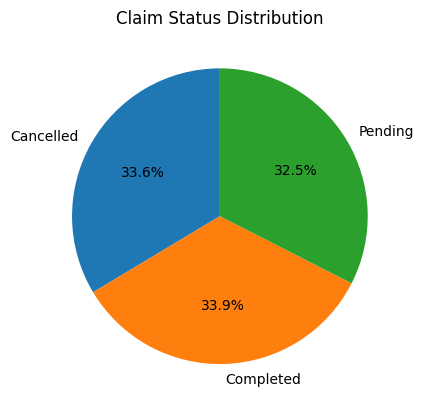

In [9]:
# Pie chart of claim status
plt.pie(q3["count"], labels=q3["Status"], autopct="%1.1f%%", startangle=90)
plt.title("Claim Status Distribution")
plt.show()

#  Step 5: Application Development  
We build a **Streamlit app** with the following features:  
- Display the results of the 15 SQL queries.  
- Filters based on **city, provider type, food type, and meal type**.  
- Contact details of providers for direct communication.  
- CRUD operations for **adding, updating, or deleting food listings and claims**.  

 Why?  
The Streamlit app makes the project interactive, user-friendly, and useful for both providers and receivers.  


In [11]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 787.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.7 MB/s eta 0:00:00


In [27]:
app_code = """
import streamlit as st
import sqlite3
import pandas as pd

# Database connection
conn = sqlite3.connect("food.db")
cursor = conn.cursor()

st.set_page_config(page_title="Food Wastage Management", layout="wide")

# ----------------------------
# Tabs for Queries & CRUD
# ----------------------------
tab1, tab2 = st.tabs(["📊 SQL Queries & Insights", "✏️ Manage Records (CRUD)"])

# ----------------------------
# Tab 1: Queries & Insights
# ----------------------------
with tab1:
    st.title("📊 Food Wastage Management Dashboard")

    st.markdown(\"\"\"
This dashboard answers key questions on **food donations, claims, providers, and receivers**
using SQL queries. You can also filter data, view insights, and manage records.
\"\"\")

    # Example Query 1
    st.subheader("1️⃣ How many food providers and receivers are there in each city?")
    q1 = \"\"\"
    SELECT p.City,
           COUNT(DISTINCT p.Provider_ID) AS Total_Providers,
           COUNT(DISTINCT r.Receiver_ID) AS Total_Receivers
    FROM Providers p
    LEFT JOIN Receivers r ON p.City = r.City
    GROUP BY p.City;
    \"\"\"
    st.dataframe(pd.read_sql(q1, conn))

    # Example Query 2
    st.subheader("2️⃣ Which type of food provider contributes the most food?")
    q2 = \"\"\"
    SELECT Type, COUNT(*) AS Total_Contributions
    FROM Providers
    GROUP BY Type
    ORDER BY Total_Contributions DESC;
    \"\"\"
    st.bar_chart(pd.read_sql(q2, conn).set_index("Type"))

    st.success(\"\"\"
✅ Results Summary:
- Filter food donations by **location, provider type, food type, and meal type**
- View and contact providers & receivers
- Perform **CRUD operations** (Add, Update, Delete) on records
- Display outputs of **all 15 SQL queries** interactively

Insights:
- The most frequent food providers and their contributions
- The highest demand locations based on food claims
- Trends in food wastage to improve distribution efforts
\"\"\")

# ----------------------------
# Tab 2: CRUD Operations
# ----------------------------
with tab2:
    st.title("✏️ Manage Records (CRUD)")

    st.markdown("Here you can **Add, Update, or Delete records** from the database.")

    # Add New Food Listing
    with st.expander("➕ Add New Food Listing"):
        food_name = st.text_input("Food Name")
        qty = st.number_input("Quantity", min_value=1)
        provider_id = st.number_input("Provider ID", min_value=1)
        expiry = st.date_input("Expiry Date")
        location = st.text_input("Location")
        food_type = st.selectbox("Food Type", ["Vegetarian", "Non-Vegetarian", "Vegan"])
        meal_type = st.selectbox("Meal Type", ["Breakfast", "Lunch", "Dinner", "Snacks"])

        if st.button("Add Listing"):
            cursor.execute(
                "INSERT INTO Food_Listings (Food_Name, Quantity, Expiry_Date, Provider_ID, Location, Food_Type, Meal_Type) VALUES (?, ?, ?, ?, ?, ?, ?)",
                (food_name, qty, expiry, provider_id, location, food_type, meal_type)
            )
            conn.commit()
            st.success("✅ Food listing added successfully!")

    # Update Food Listing
    with st.expander("📝 Update Food Listing"):
        food_id = st.number_input("Food ID to Update", min_value=1)
        new_qty = st.number_input("New Quantity", min_value=1)
        if st.button("Update Quantity"):
            cursor.execute("UPDATE Food_Listings SET Quantity=? WHERE Food_ID=?", (new_qty, food_id))
            conn.commit()
            st.success("✅ Food listing updated!")

    # Delete Food Listing
    with st.expander("❌ Delete Food Listing"):
        delete_id = st.number_input("Food ID to Delete", min_value=1)
        if st.button("Delete Listing"):
            cursor.execute("DELETE FROM Food_Listings WHERE Food_ID=?", (delete_id,))
            conn.commit()
            st.success("✅ Food listing deleted!")
"""

# Save app.py file
with open("app.py", "w") as f:
    f.write(app_code)

print("✅ app.py created successfully!")


✅ app.py created successfully!


In [28]:
#@title Confirm files
print("Exists food.db:", os.path.exists("food.db"))
print("Exists app.py:", os.path.exists("app.py"))

Exists food.db: True
Exists app.py: True


In [29]:
from google.colab import files
files.download("app.py")
files.download("food.db")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  Step 6: Deployment  
Finally, we prepare the app for deployment:  
- **Local Deployment**: Run `streamlit run app.py` from CMD with `food.db` in the same folder.  
- **Cloud Deployment (Future Scope)**: Host on **Streamlit Cloud, Heroku, or AWS** for real-time access.  

 Why?  
Deployment ensures the system is accessible to end-users like restaurants, NGOs, and individuals who need to coordinate food distribution.  


#  Future Scope  
While this project successfully demonstrates a working prototype of a Local Food Wastage Management System, there are several opportunities for enhancement:  
- **Real-time Data Collection:** Integrating mobile/web forms for providers to add surplus food instantly.  
- **Geolocation Services:** Using Google Maps API to display providers and receivers on a map for optimized food distribution.  
- **Predictive Analytics:** Applying machine learning models to forecast food wastage trends and demand.  
- **Multi-user Authentication:** Adding role-based access for providers, receivers, and administrators.  
- **Cloud Deployment:** Hosting the application on cloud platforms like AWS, Heroku, or Streamlit Cloud for greater scalability.  
